In [268]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [269]:
categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]
# categories = None
remove = ('headers', 'footers', 'quotes')
print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


In [270]:
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

data loaded


In [271]:
# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))
print()

2034 documents - 2.428MB (training set)
1353 documents - 1.800MB (test set)
4 categories



In [302]:
# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                             stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()
feature_names = vectorizer.get_feature_names()
results = []

Extracting features from the training data using a sparse vectorizer
done in 0.434407s at 5.589MB/s
n_samples: 2034, n_features: 26576

Extracting features from the test data using the same vectorizer
done in 0.281255s at 6.399MB/s
n_samples: 1353, n_features: 26576



In [303]:
# num_grid = 1000
# print("Extracting %d best features by a chi-squared test" %
#           num_grid)
# t0 = time()
# ch2 = SelectKBest(chi2, k=num_grid)
# X_train = ch2.fit_transform(X_train, y_train)
# X_test = ch2.transform(X_test)
# if feature_names:
#     # keep selected feature names
#     feature_names = [feature_names[i] for i
#                      in ch2.get_support(indices=True)]


# print("done in %fs" % (time() - t0))


print()
feature_names = np.asarray(feature_names)
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

# # Feature Scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

def benchmark(clf):
#     print("Training: ")
#     print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
#     print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
#     print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    print()

    if hasattr(clf, 'coef_'):
#         print("selecting top %d features using chi-square: %d" % (num_grid, clf.coef_.shape[1]))
        print("dimensionality: %d" % clf.coef_.shape[1])
#         print("density: %f" % density(clf.coef_))

#         if feature_names is not None:
#             print("top 10 keywords per class:")
#             for i, label in enumerate(target_names):
#                 top10 = np.argsort(clf.coef_[i])[-10:]
#                 print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    print("classification report:")
    print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))


    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

print("LinearSVC with L2 Regularization and without Feature Scaling")
print()
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(LinearSVC(penalty="l2", max_iter=5000)))


LinearSVC with L2 Regularization and without Feature Scaling

accuracy:   0.780

dimensionality: 26576

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.70      0.62      0.66       319
     comp.graphics       0.89      0.91      0.90       389
         sci.space       0.78      0.90      0.84       394
talk.religion.misc       0.68      0.60      0.64       251

          accuracy                           0.78      1353
         macro avg       0.76      0.76      0.76      1353
      weighted avg       0.77      0.78      0.78      1353

confusion matrix:
[[198  11  48  62]
 [  7 353  25   4]
 [ 17  20 353   4]
 [ 62  13  25 151]]



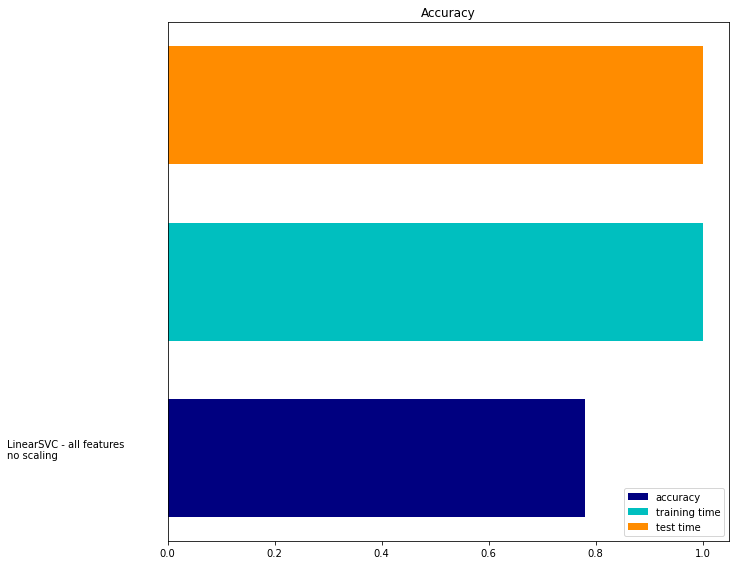

In [304]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Accuracy")
plt.barh(indices, score, .2, label="accuracy", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
#     plt.text(-.3, i, c + ' - ' + str(num_grid) + ' features')
    plt.text(-.3, i, c + ' - all features \nno scaling')

plt.show()